# Diffusion Models From Start To End

No one have probably missed the recent boom and hype around Diffusion Models and their amazing results. Creating the most unimaginable images when for example given a text description. And models that top the previous best model seem to arrive every other week. Some of the best are [DALL-E 2](https://openai.com/dall-e-2/), [Imagen](https://imagen.research.google/) and a couple of weeks ago Stability AI open sourced the powerful [Stable Diffusion](https://stability.ai/blog/stable-diffusion-public-release) model whom anyone can download and run. It is also fast enough to run locally on your own machine if you have a decent GPU. [Here](https://www.assemblyai.com/blog/how-to-run-stable-diffusion-locally-to-generate-images/) are instructions on how to do it, and if you have a M1 Mac there is even an [optimized app for that](https://diffusionbee.com).

Now I have to admit that I have just barely scratched the surface of diffusion models and their details, I blame it on the impossible task of keeping up with high pace in the current machine learning community. So this post is about getting myself end hopefully others up to speed by implementing a diffusion model in PyTorch, train it on a dataset and touch on the details that make these models work. It will not be a dive to the depth of the ocean, in those cases I will link to good resources that I have found useful for a deep understanding of the math and derivations behind the equations. I will mix theory and implementation as I go along and the model trained will only generate images without being conditioned on any other modality, such as text, to make training feasible.

### Intro and High-level Intuition
So the basic idea of diffusion models is to learn a model that can create samples from some distribution, for example natural images, from just noise. An analogy I like to have in mind is that the models are similar to a human forming a lump of clay into for example a cup, we start with something containing no information and slowly form something useful. And we do this by our own approximation of the distribution of how a cup can be made from the lump of clay. There are infinite many ways we can go from lump of clay to cup and we can't learn everyone, but we don't have to, we only need to learn a subset that are "good enough". This is the core of diffusion models on a high level.

### Two Phases
The setup when training a diffusion model have two phases, a forward diffusion process, in which we over a set of timesteps $0:T$ add noise to a sample $\mathbf{x}_0$ so we end up with the sample at time $T$ only consisting of isotropic (uniform in all dimensions) gaussian noise with mean zero and variance one. Then we have a backward diffusion process where we do the opposite, go from the noise $\mathbf{x}_T$ to the initial sample $\mathbf{x}_0$. It is this backward process we want to learn. The forward process is usually fixed and is just consisting of a noise scheduler which tells how much noise to add at each timestep. Lets start with digging into the forward process and take it from there.

#### Forward Diffusion Process

The noise is added by a variance schedule, $\{\beta\in(0,1)\}_{t=1}^{T}$, we will use a linear one. Lets create a function for that.

In [1]:
import torch

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """Creates a linear noise schedule"""
    return torch.linspace(start, end, timesteps)

Adding gaussian noise from one time step to the next is then defined by

$$
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}\left(\mathbf{x}_t ; \sqrt{1 - \beta_t}\mathbf{x}_{t-1} , \beta_t\mathbf{I}\right)
$$

And the complete forward process can be written as

$$
q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0}) = \prod_{t=1}^{T}q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
$$

One can see that as $t$ increases we go towards a normal distribution with zero mean and unit variance. If we then define a variable $\alpha_t \doteq 1 - \beta_t$ and use the fact that sampling from any normal distribution can be written as the mean plus the variance times $\epsilon$, where $\epsilon \sim \mathcal{N}(0, \mathbf{I})$ (also known as the re-parameterization trick) one can show that

$$
\mathbf{x_t} = \sqrt{\bar{\alpha_{t}}} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha_{t}}}\epsilon
\quad \Rightarrow \quad
q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\bar{\alpha_{t}}} \mathbf{x}_0 , (1 - \bar{\alpha_{t}})\mathbf{I})
$$

Where $\bar{\alpha_t} = \prod_{i=0}^{t}\alpha_i$. So we see that we can sample $\mathbf{x_t}$ at any time $t$ given just $\mathbf{x}_0$, i.e we can sample in closed form. This because a sums of gaussians is also gaussian. See [Lilian's excellent post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) for derivation and details.

Our forward diffusion process can then be implemented as

In [2]:
import torch.nn.functional as F

# Number of time steps in the diffusion process
T = 300

# Create the betas
betas = linear_beta_schedule(timesteps=T)

# Pre-calculations
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)


def get_val_from_t(vals, t, x_shape):
    """
    Helper to get specific t's of a passed list of values 'vals' and returning them with the same dimensions as 'x_shape'
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    
    # reshape and add correct dimension and move to same device as 't'
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device="cpu"):
    """
    Takes an initial image 'x_0' and a time step 't' and returns the 
    noisy version of the image at time 't' and the noise applied
    """
    noise = torch.randn_like(x_0).to(device)

    sqrt_alphas_cumprod_t = get_val_from_t(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    sqrt_one_minus_alphas_cumprod_t = get_val_from_t(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)
    
    return (
        sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise,
        noise
    )

### Dataset

In order to test the forward diffusion we need some data. We are going to use the StanfordCars dataset and for our purpose we only need to know it is a lot of images of cars, around 8000 in the training set. Let us download it ( if you running this on your own machine keep in mind it is $\sim$ 1GB)

In [4]:
import torchvision

dataset = torchvision.datasets.StanfordCars(root='/mnt/37bdf30c-6275-4c74-8911-fe112425def1/dataset/DDPM',
                                            split='train',
                                            download=True)

To get a feeling of the images we plot some examples

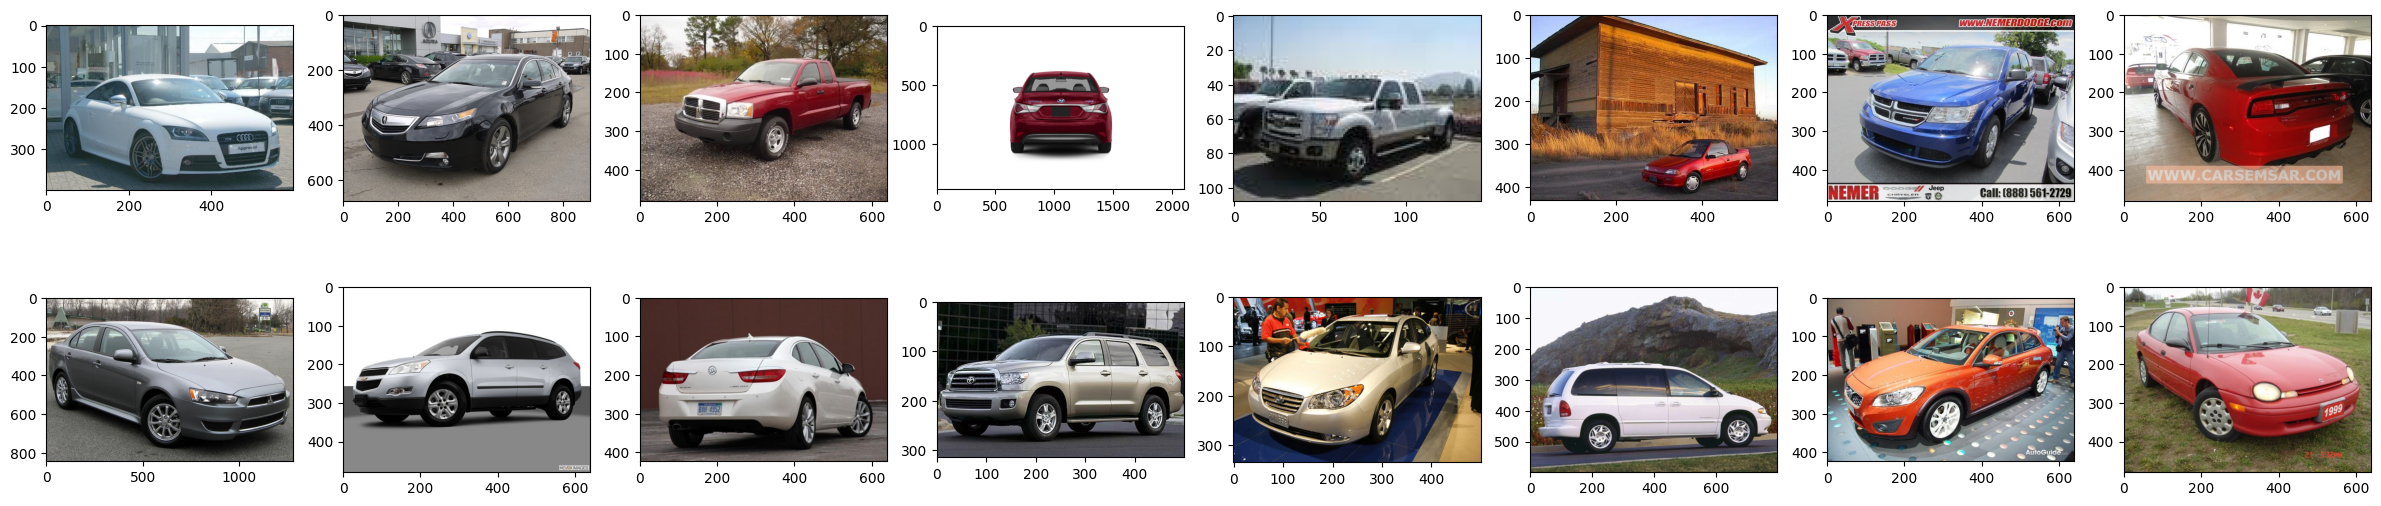

In [5]:
import matplotlib.pyplot as plt

def plot_images(dataset, num_samples=16, cols=8):
    plt.figure(figsize=(30, 10))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img[0])

plot_images(dataset)
plt.show()

##### Transform the data

The images are in PIL format and we need them as torch tensors, this can be done using the following code

In [6]:
from torchvision import transforms 

# resolution to use
IMG_SIZE = 32

dataset_transformed = torchvision.datasets.StanfordCars(root='/mnt/37bdf30c-6275-4c74-8911-fe112425def1/dataset/DDPM',
                                                        transform=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # convert values to be between [-1.0,  1.0]
    transforms.Lambda(lambda x: (x * 2) - 1)
]))

We scale the image to a more resonable resolution (high resolution is very memory expensive), we also perform random horizontal flip in order to make our model more generic when it comes to orientation. Lastly we convert the image to a tensor and scale the pixel values to be between -1.0 and 1.0 since we are working with gaussians. 

Now we are ready to test our forward diffusion process

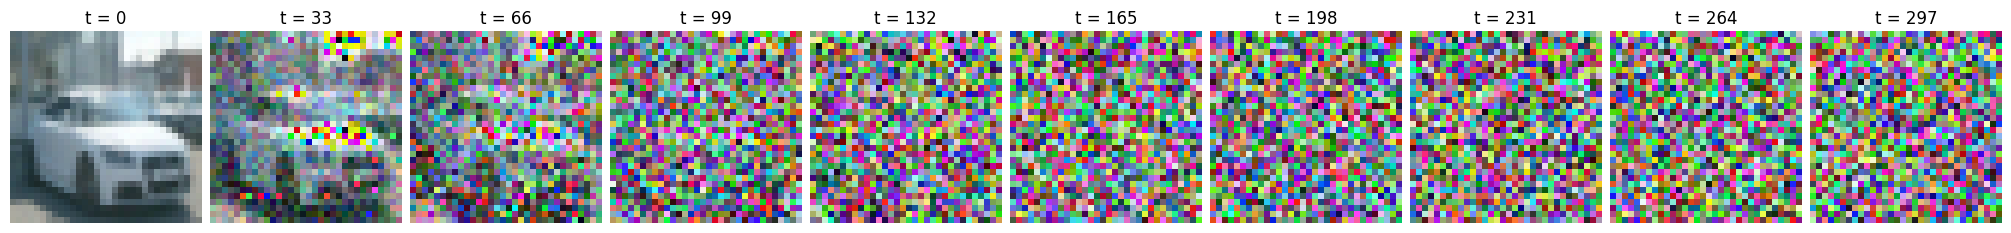

In [7]:
import numpy as np

def tensor_to_pil(image):
    """Reverse the transformation"""
    reverse_transforms = transforms.Compose([
        # back to [0, 1] for the values
        transforms.Lambda(lambda t: (t + 1) / 2),
        # CHW to HWC
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), 
        # convert to range [0, 255]
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    return reverse_transforms(image)

# take an image
image_0 = dataset_transformed[0][0]

# since plotting 'T' number of images is a bit much we decrease it
num_images = 10
stepsize = T // (num_images - 1)

# plot the image for different t's
fig, ax = plt.subplots(1, num_images, figsize=(20, 20), constrained_layout=True)
for ind in range(0, num_images):

    t = stepsize * ind
    tt = torch.Tensor([t]).type(torch.int64)

    image_t, _ = forward_diffusion(image_0, tt)
    ax[ind].axis("off")
    ax[ind].set_title(f"t = {t}")
    ax[ind].imshow(tensor_to_pil(image_t))

Seems to work quite well. Just to get indication that the last image $\mathbf{x}_T$ indeed is similar to noise drawn from $\sim \mathcal{N}(0, \mathbf{I})$ we can check to mean and standard deviation across the image

In [8]:
std, mean = torch.std_mean(image_t)
print(f"Mean: {mean:.2f} Std: {std:.2f}")

Mean: 0.03 Std: 0.95


Quite close, you an try and change $T$ and as you increase it we will get closer to the wanted distribution $\mathcal{N}(0, \mathbf{I})$. Note here that a more rigorous way would be to sample a batch of images and check mean and standard deviation across all dimensions, but lets be satisfied and continue.

### Reverse diffusion process

So how do we go back? From noise to the original image? It might at first feel trivial since it was so easy to arrive at the noisy version. But remember, at each step when adding noise we lose a lot of information in a statistical fashion. In other words, we create an extremely large amount of possible ways to go back. In fact, to reverse the process and get back the original distribution we would have to integrate (marginalize) over all possible ways we could arrive at the original image $\mathbf{x_0}$ including all the latent (non observed) variables on the way. This is understandably intractable in the case of natural images. So the only way we could manage this is by approximation!

Here comes neural networks, once again, to the rescue. So, the idea is to train a neural network parameterized by $\theta$ to approximate the true distribution

$$ q(\mathbf{x}_{t-1} \vert \mathbf{x}_{t}) \approx p_{\theta}(\mathbf{x}_{t-1} \vert \mathbf{x}_{t})$$

The first obvious way to do this would be to estimate the mean and covariance for each denoising step.

$$p_{\theta}(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mu_{\theta}(\mathbf{x}_t, t), \Sigma_{\theta}(\mathbf{x}_t, t))$$

However the authors of the [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239v2.pdf) paper explored an alterative parameterization. Instead of estimating $ \mu_{\theta}(\mathbf{x}_t, t)$ we can make the network predict the noise added at each time step, $\epsilon_{\theta}(\mathbf{x}_t, t)$. This since it can be shown that (jump into the [paper]((https://arxiv.org/pdf/2006.11239v2.pdf)) for the derivation)

$$ 
\mu_{\theta}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}} \epsilon_{\theta}(\mathbf{x}_t, t) \right)
$$

This makes it possible to simplify the variational lower bound while maintaining performance, sounds a bit scary but let's leave it there for now.

Further more they fix $\Sigma_{\theta}(\mathbf{x}_t, t)$ and set it to 

$$
\Sigma_{\theta}(\mathbf{x}_t, t) = \sigma_t^2\mathbf{I} = \tilde{\beta_t}\mathbf{I} = \frac{1 - \bar{\alpha}_{t-1}}{1- \bar{\alpha}_t}\beta_t\mathbf{I}
$$

The reason for this is because it can be shown that $q(\mathbf{x}_{t-1} \vert \mathbf{x}_{t})$ is tractable when conditioned on $\mathbf{x}_0$ and

$$
q(\mathbf{x}_{t-1} \vert \mathbf{x}_{t},\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_{\theta}(\mathbf{x}_t, t), \tilde{\beta}_t\mathbf{I})
$$

So when the network have predicted the noise added by one forward step we get the real image by

$$
\begin{aligned}
\mathbf{x}_{t-1} 
&= \mu_{\theta}(\mathbf{x}_t, t) + \sqrt{\tilde{\beta}_t}\epsilon \\
&= \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}} \epsilon_{\theta}(\mathbf{x}_t, t) \right) + \sqrt{\tilde{\beta}_t}\epsilon
\end{aligned}
$$

We can now implement a function for sampling from our model that we later will use during training and inference

In [9]:
# pre-calculate some variables
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod) * betas
sqrt_one_over_alphas = torch.sqrt(1.0 / alphas)


@torch.no_grad()
def sample_timestep(x, t, model, device):
    """
    Samples images from 'model' given image 'x' and time 't'
    """

    betas_t = get_val_from_t(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_val_from_t(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_one_over_alphas_t = get_val_from_t(sqrt_one_over_alphas, t, x.shape)
    
    posterior_mean_t = sqrt_one_over_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * model(x, t))
    posterior_variance_t = get_val_from_t(posterior_variance, t, x.shape)
    
    # do not add noise if we are at t = 0
    noise = torch.randn_like(x) if t > 0 else 0.0

    return posterior_mean_t + torch.sqrt(posterior_variance_t) * noise 

Let us also create a helper function so we can sample a number of images from our model so we later can log a bunch images for the results

In [10]:
@torch.no_grad()
def sample_images(model, device, num_samples = 5, images_per_sample = 10):
    """
    Helper function to sample 'num_samples' images from the model 
    and 'images_per_sample' images for each sample spread out between t = [0, T]
    """

    # tensor to store the results
    images = torch.empty((num_samples, num_images, 1, 3, IMG_SIZE, IMG_SIZE))

    stepsize = int(T/num_images)
    for sample in range(num_samples):

        # sample noise
        img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)

        # loop backwards
        for i in range(0, T)[::-1]:

            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = sample_timestep(img, t, model, device=device)

            if i % stepsize == 0:
                # store sample image
                col = num_images - i // stepsize - 1
                images[sample, col] = img.detach().cpu()
    
    return images

### Training objective

So now there is only one thing missing, how do we know that our network's approximation of $q(\mathbf{x}_{t-1} \vert \mathbf{x}_{t})$ is actually good? What metric can we use to measure it? The answer to this lies within a domain called [*Variational Inference*](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) where the core is to say (infer) something about some unobserved (latent) variable by optimizing for a function (in our case $p_{\theta}(\mathbf{x}_{t-1} \vert \mathbf{x}_{t})$ ). More over we are going to use something called Varational Lower Bound (VLB) or Evidence Lower Bound (ELBO), the derivation is a bit cumbersome, but lets try and get the gist of it. We are ging to start from the [*Kullback-Leibler Divergence*](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) which is a measure of how similar two distrubtions are

$$\mathbf{D}_{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}}P(x)\log\left(\frac{P(x)}{Q(x)}\right)$$

Lets plug in our distributions, switch to the continuous realm and include the complete sequence

$$\mathbf{D}_{KL}(q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0}) \parallel p_{\theta}(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})) = \int q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})\log\left(\frac{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}{p_{\theta}(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\right) d\mathbf{x}_{1:T}$$

Here we say that given the initial image $\mathbf{x}_0$ we want the joint probability of the latent variables $\mathbf{x}_{1:T}$ to be the same for both distributions, which is a property we want. Lets work with this expression a bit more

$$
\begin{aligned}
\mathbf{D}_{KL}(q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0}) \parallel p_{\theta}(\mathbf{x}_{1:T} \vert \mathbf{x}_{0}))
&=\int q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})\log\left(\frac{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}{p_{\theta}(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\right) d\mathbf{x}_{1:T} \\
&= \int q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})\log\left(\frac{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0}) p_{\theta}(\mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{0:T})}\right) d\mathbf{x}_{1:T} & \scriptsize{\text{Use that } p(a \vert b) = p(a, b)p(b)} \\
&=\mathbb{E}_{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\Big[ \log\left(\frac{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0}) p_{\theta}(\mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{0:T})}\right) \Big] & \scriptsize{\text{From the definition of expectation}} \\
&=\mathbb{E}_{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\Big[ \log\left(\frac{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}{p_{\theta}(\mathbf{x}_{0:T})}\right) \Big] + \mathbb{E}_{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\Big[\log{p_{\theta}(\mathbf{x}_0)}\Big] & \scriptsize{\text{Split expectation into two}} \\
&=\mathbb{E}_{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\Big[ \log\left(\frac{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}{p_{\theta}(\mathbf{x}_{0:T})}\right) \Big] + \log{p_{\theta}(\mathbf{x}_0)}& \scriptsize{\text{The last term does not depend of q so the expectation can be removed}} \\
&=-\mathbb{E}_{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\Big[ \log\left(\frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\right) \Big] + \log{p_{\theta}(\mathbf{x}_0)}& \scriptsize{\text{Flip the logarithm}} \\
\end{aligned}
$$

Look at the last term on the RHS $\log{p_{\theta}(\mathbf{x}_0)}$, it is the log-likelihood of the distribution producing real images, which is exactly what we would like to maximize! The first term on the RHS is what is called the **Variational Lower Bound** defined as

$$
\mathcal{L}_{VLB} = \mathbb{E}_{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\Big[ \log\left(\frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})}\right) \Big]
$$

Let us write the equation bit less verbose

$$
\mathbf{D}_{KL} = \log{p_{\theta}} - \mathcal{L}_{VLB}
$$

Why is it called the **Variational Lower Bound** and why is it useful. Let us reason a bit about the terms, $\log{p_{\theta}}$ is always $\le0$ because the logarithm will be of values between 0 and 1. The $\mathbf{D}_{KL}$ is always $\ge0$ since it is a distance. So to make the equation valid $\mathcal{L}_{VLB}$ must be $\le0$. Add to this that in general $\mathbf{D}_{KL}$ is $>0$ otherwise we would have a perfect approximation of the target distribution, so this makes $\mathcal{L}_{VLB}$ have to be smaller than $\log{p_{\theta}}$, hence it is a lower limit or a **lower bound** of $\log{p_{\theta}}$. 

So it turns out that we can compute the lower bound and by maximize it we push up $\log{p_{\theta}}$ which is our goal. I really recommend watching [this video](https://www.youtube.com/watch?v=HxQ94L8n0vU) to get a deeper intuition about the **Variational Lower Bound**.
<br/>
<br/>
The last derivation of how we reach the final loss function I leave out, but you can once again see [Lilian's great post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) or [Sohl-Dickstein et al., 2015](https://arxiv.org/abs/1503.03585) for even more details, but after some massaging one can conclude that the $\mathcal{L}_{VLB}$ can be expanded into a sum of KL-divergence's and really the only term we need to care about is

$$
\mathcal{L}_{VLB,t} = D_\text{KL}(q(\mathbf{x}_t \vert \mathbf{x}_{t+1}, \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_t \vert\mathbf{x}_{t+1})) \text{ for }1 \leq t \leq T-1
$$

which can be computed in closed form since it as a comparison of two gaussians and further it can be shown that

$$
\mathcal{L}_{VLB,t} = \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \Big[\frac{ (1 - \alpha_t)^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \boldsymbol{\Sigma}_\theta \|^2_2} \|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)\|^2 \Big]
$$

Yes, your vision is correct, after all this we are almost back at the classical mean squared error. In fact [Ho et al. (2020)](https://arxiv.org/pdf/2006.11239v2.pdf) found that the model even works better if we drop the weighting term, so our final training loss becomes just

$$
\mathcal{L}_{VLB,t} = \|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)\|^2
$$

We can sample this loss for different $t$ given an initial image $\mathbf{x}_0$ and then update our network with the gradients as usual. Lets implement this loss.

In [11]:
import torch.nn.functional as F

def get_loss(model, x_0, t, device):

    # get noisy image and the noise from the forward diffusion
    x_t, noise = forward_diffusion(x_0, t, device)

    # predict the noise given noisy image and t
    noise_pred = model(x_t, t)
    
    return F.mse_loss(noise, noise_pred)

### Network Architecture

We will use almost the same architecture as [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239v2.pdf) and I have taken the great implementation from [Lucidrains](https://github.com/lucidrains/denoising-diffusion-pytorch) and simplified it a bit. I won't go through the architecture since the code for implementing the network is pretty long and not really the core of this exploration. But on a very high level the architecture is a [U-Net](https://en.wikipedia.org/wiki/U-Net) with baked-in attention and positional encoding. If you want to take a look at it you can click and expand the code below.

In [12]:
from functools import partial
import math
from tokenize import group

import torch
from torch import nn
from einops import reduce, rearrange


def l2norm(t):
    return F.normalize(t, dim = -1)


class UNet(nn.Module):
    def __init__(self, img_channels: int, init_dim: int, time_emb_dim: int, num_res: int = 4):
        """Creates a UNet

        Args:
            in_channels (int): number of images channels
            init_dim (int): number of output channels in the first layer
            time_emb_dim (int): time dimension size
            num_res (int, optional): Number of resolutions
        """
        super().__init__()
        
        # initial conv
        self.init_conv = nn.Conv2d(img_channels, init_dim, kernel_size=7, padding=3)
        
        # create list of the different dimensions
        dims = [init_dim, *map(lambda m: init_dim * m, [2**res for res in range(0, num_res)])]

        # create convenient list of tuples with input and output channels for each resolution
        in_out_dims = list(zip(dims[:-1], dims[1:]))
        
        # time embedding block
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(init_dim),
            nn.Linear(init_dim, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # downsample
        self.down_layers = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out_dims):
            is_last = ind >= num_res - 1
            
            self.down_layers.append(nn.ModuleList([
                ResNetBlock(dim_in, dim_in, time_emb_dim=time_emb_dim),
                ResNetBlock(dim_in, dim_in, time_emb_dim=time_emb_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
            ]))
        
        # middle block
        mid_dim = dims[-1]
        self.mid_block1 = ResNetBlock(mid_dim, mid_dim, time_emb_dim=time_emb_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = ResNetBlock(mid_dim, mid_dim, time_emb_dim=time_emb_dim)
        
        # upsample
        self.up_layers = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out_dims)):
            is_last = ind == num_res - 1
            
            self.up_layers.append(nn.ModuleList([
                ResNetBlock(dim_in + dim_out, dim_out, time_emb_dim=time_emb_dim),
                ResNetBlock(dim_in + dim_out, dim_out, time_emb_dim=time_emb_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1)
            ]))
        
        self.final_res_block = ResNetBlock(init_dim * 2, init_dim, time_emb_dim = time_emb_dim)
        self.final_conv = nn.Conv2d(init_dim, img_channels, 1)
    
    def forward(self, x, time):

        x = self.init_conv(x)

        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.down_layers:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)
        
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.up_layers:

            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class ResNetBlock(nn.Module):
    def __init__(self, dim_in, dim_out, time_emb_dim, groups = 8):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        )
        
        self.block1 = Block(dim_in, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim_in, dim_out, 1) if dim_in != dim_out else nn.Identity()
    
    def forward(self, x, t, time_emb = None):
        
        scale_shift = None
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)
        
        
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x
        

def Upsample(dim_in, dim_out):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim_in, dim_out, 3, padding = 1)
    )

def Downsample(dim_in, dim_out = None):
    return nn.Conv2d(dim_in, dim_out, 4, 2, 1)

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
    
class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g
    
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, scale = 10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = torch.einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

Create a model and print number of parameters

In [13]:
model = UNet(img_channels=3, init_dim=64, time_emb_dim=32)
print(f"Num params: {sum(p.numel() for p in model.parameters()):,}")

Num params: 34,366,147


34 million should be low enough to train in a reasonable amount of time

### Training

It is finally time to start training. We are going to use PyTorch Lightning which removes a lot of the boilerplate training code. In order to do this we first we need to wrap the model in a LightningModule where we define the training step and the logging of our loss and images to Tensorboard.

In [14]:
import pytorch_lightning as pl
import torch
import torchvision

class LightningModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()

        # just wrap the model
        self.model = model

    def forward(self, x, t):
        return self.model(x, t)

    def training_step(self, batch, batch_idx):
        """Here we do the optimization"""

        # batch is in a list
        batch = batch[0]

        batch_size = batch.shape[0]

        # sample timesteps
        t = torch.randint(0, T, (batch_size,), device=self.device).long()

        # calc the loss
        loss = get_loss(self.model, batch, t, device=self.device)

        # log loss to tensorboard
        self.log("Loss", loss, on_step=True, on_epoch=True)
        
        return loss

    def on_train_epoch_end(self) -> None:
        """Function that runs when an epoch has been trained"""
        
        # every 10 epoch we sample images and log to tensorboard
        if self.trainer.current_epoch % 10 == 0:
            images = sample_images(model=self.model, device=self.device)
            img_h, img_w = images.shape[-2:]
            image_grid = torchvision.utils.make_grid(images.reshape(-1, 3, img_h, img_w), nrow=images.shape[1], normalize=True)
            self.logger.experiment.add_image('Model samples', image_grid, self.trainer.current_epoch)
        
        return super().on_epoch_end()
    
    def configure_optimizers(self):
        """Define our optimizer"""
        return torch.optim.Adam(model.parameters(), lr=0.0002)


Then we start the training. We train for 1000 epochs with a batch size of 128 and using the Adam optimizer with a learning rate of 0.0002. 

In [15]:
from torch.utils.data import DataLoader, Subset

# Select a subset of the data in order to converge faster
dataset_transformed = Subset(dataset_transformed, range(0, 3000))

dataloader = DataLoader(
    dataset_transformed, 
    batch_size=128, 
    shuffle=True, 
    drop_last=True, 
    num_workers=24
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,              
    precision=32,
    max_epochs=1000,
    logger=True,
    log_every_n_steps=1
)
model = LightningModel(model)
trainer.fit(model, dataloader)

/home/zhang/anaconda3/envs/DDPM/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/zhang/anaconda3/envs/DDPM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger

Training: 0it [00:00, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 3.80 GiB total capacity; 2.88 GiB already allocated; 47.88 MiB free; 3.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Results and Samples

In the beginning the samples from the model is basically just noise

<img src = "images/epoch-10.png" width="500">

But already at 60 epochs we start to see something that might resemble a car but still with a very abstract touch.

<img src = "images/epoch-60.png" width="500">

And after training for about 2 hours and 1000 epochs the samples actually looks like cars. Still very low resolution and full with artifacts, but still decent considering the relative small model and short training time.

<img src = "images/epoch-990.png" width="500">

Below is a plot of the loss. The model converge nicely and could probably have trained for quite sometime more before stagnating.

<img src = "images/loss-light.png">

### Conclusions

The math behind diffusion models is a quite complex thanks to the probabilistic nature, but in the end actually implementing one is very straightforward. This might make you ask if this whole probability framework is really needed. It might be that it is not, a recent paper [*Cold Diffusion: Inverting Arbitrary Image
Transforms Without Noise*](https://arxiv.org/pdf/2208.09392.pdf) show that you can have completely deterministic diffusion processes and still make the models work. Sound quite promising, and simplicity usually wins long term.

While the latest Text-to-Image diffusion models are remarkable, one thing I'm excited about are apply diffusion models to generate videos or Text-to-Video (T2V). And as I was finalizing this post MetaAI released there new [*Make-A-Video*](https://makeavideo.studio/). The cool thing about this model is that is not trained on text-video data but instead on text-image as usual, but then they learn how the world "moves" using unsupervised video and combine these to outputs to generate the videos. 



<p align = "center">
    <img src = "https://make-a-video.github.io/assets/T2V_samples/webp/2/Robot_dancing_in_times_square_second_upsample.webp" width="300">
</p>
<p align = "center">
    <small>Video generated by MetaAI's Make-A-Video model given the input <i>Robot dancing in times square</i>. <a href="https://make-a-video.github.io/">source</a></small>
</p>

Sure, they are far from looking realistic, but a few papers down the road I'm sure they will start to look scary good, and the next model is most likely already getting baked in th GPUs.